From previous experiment, we found the difficulty in predicitng stock prices and returns. 
Therefore, now I will experiment predicting the next price will go up/down by binary classification.\(dataset: Starbacks stock 2013-2018)\
I have taken two different approach for each method 
- One step forecast
- Multistep forecast


\
I have tried \
- LSTM

In conclusion, as it proved, it is not quite feasible to predict even just up/down trend by using these model and method. From the accuracy staying around 50%, it is almost same as random guess. 


In [1]:
import tensorflow as tf
print('tf version: ', tf.__version__)

tf version:  2.11.0


In [2]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [37]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [38]:
#calculate returns by shifting the data
df['PrevClose'] = df['close'].shift(1) #move everything down 1

#so now it is like
#close / prev close
#x[2] x[1]


In [39]:
#Then retun is

#(x[t] - x[t-1] / x[t-1])
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [40]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


Normalize the dataset

In [41]:
series = df['Return'].values[1:].reshape(-1, 1)

#Normalize the data
#Note:This boundary is just random approximation
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()


In [42]:
##Turn the full data into numpy arrrays
#Not yet in the final "X" format
input_data = df[['open', 'high', 'close', 'volume']].values
targets = df['Return'].values

In [43]:
##Now create the actual data which will go into the neural network
T = 10  #The number of time steps go look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T #(e.g if T = 10 and you have 11 data points then you'd only have 1)

Normalize the input

In [44]:
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain + T])
input_data = scaler.transform(input_data)

In [45]:
#Set up X_train and Y_train
X_train = np.zeros((Ntrain, T, D))
Y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t, :, :] = input_data[t:t+T]
  Y_train[t] = (targets[t+T] > 0)

In [46]:
#Set up Test Set
X_test = np.zeros((N - Ntrain, T, D))
Y_test = np.zeros(N - Ntrain)

for u in range(N - Ntrain):
  #u counts from 0 ... (N - Ntrain)
  #t counts from Ntrain .... N
  t = u + Ntrain
  X_test[u, :, :] = input_data[t:t+T]
  Y_test[u] = (targets[t+T] > 0)

Build RNN model

In [47]:
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'],
)

In [48]:
##Train Model
r = model.fit(
    X_train, Y_train,
    batch_size = 32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 5s 34ms/step - loss: 0.6994 - accuracy: 0.5066 - val_loss: 0.6935 - val_accuracy: 0.4805
Epoch 2/300
27/27 [==============================] - 0s 11ms/step - loss: 0.6966 - accuracy: 0.4779 - val_loss: 0.6959 - val_accuracy: 0.4756
Epoch 3/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6928 - accuracy: 0.5232 - val_loss: 0.6949 - val_accuracy: 0.4829
Epoch 4/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6933 - accuracy: 0.5209 - val_loss: 0.6928 - val_accuracy: 0.5073
Epoch 5/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6936 - accuracy: 0.5209 - val_loss: 0.6931 - val_accuracy: 0.5024
Epoch 6/300
27/27 [==============================] - 0s 10ms/step - loss: 0.6918 - accuracy: 0.5268 - val_loss: 0.6930 - val_accuracy: 0.5073
Epoch 7/300
27/27 [==============================] - 0s 9ms/step - loss: 0.6923 - accuracy: 0.5268 - val_loss: 0.6943 - val_accuracy: 0.4927
Epoch 8/3

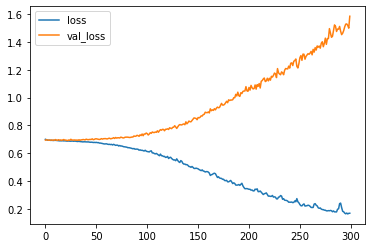

In [49]:
#Plot loss per iteration
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()

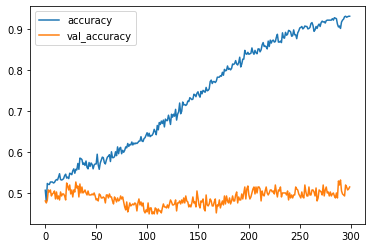

In [50]:
#Plot loss per iteration
plt.plot(r.history['accuracy'], label="accuracy")
plt.plot(r.history['val_accuracy'], label="val_accuracy")
plt.legend()